# Thermal model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import AutoMinorLocator , MaxNLocator , MultipleLocator
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy import constants as c
import pandas as pd
import CoolProp
import CoolProp.CoolProp as CP
import glob
import os
import math
import pandas as pd
from sympy import symbols, solve, exp , log
import openpyxl
import seaborn as sns
#x = symbols('x')
import warnings
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import binarize
from scipy.optimize import root, fsolve
from matplotlib.lines import Line2D
from tqdm import tqdm
import scipy.integrate as integrate

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],  # Use Times New Roman as the default font
})
sns.set_context("paper", font_scale=1.5)

## Results folder

In [27]:
# Define results folder path
results_folder = os.path.join(os.getcwd(), 'results')
os.makedirs(results_folder, exist_ok=True)

## Experimental data

In [10]:
file_path = 'exp_data/exp_data.csv'
df = pd.read_csv(file_path)

## Radiation - View factors

In [3]:
def VF_disk_to_disk(R1, R2, a, b, d):
    '''
    R1: Radius of the big disk emitting radiation - in meters
    R2: Radius of the small disk receiving radiation - in meters
    a : Offset of the small disk of radius R2 in x-dir - in meters
    b : Offset of the small disk of radius R2 in y-dir - in meters
    d : Vertical distance between the disks - in meter
    '''
    A2 = np.pi * R2**2  # area of first surface

    c = 1/(2 * np.pi * A2)

    def f1(v, u):
        x = R2 * np.cos(u) + a - R1 * np.cos(v)
        y = R2 * np.sin(u) + b - R1 * np.sin(v)
        z = d 
        R_dist = np.sqrt(x**2 + y**2 + z**2)
        dudv   = R1 * R2 * np.cos(u - v)
        return np.log(R_dist) * dudv

    # Perform integration
    int1, _ = integrate.dblquad(f1, 2*np.pi, 0, lambda u: 0, lambda u: 2*np.pi)
    

    F_01 = c * int1
    return F_01

def VF_disk_to_cylinder(R1, R2, a, b, d, L):
    """
    Compute the view factor from a disk to the interior surface of a cylinder.
    
    Parameters:
        R1 : float — radius of the disk
        R2 : float — radius of the cylinder
        a, b : float — offsets in x and y between centers
        d : float — distance from the disk to the bottom of the cylinder
        L : float — height of the cylinder

    Returns:
        View factor (float)
    """
    A_disk = np.pi * R1**2

    c = 1/( 2 * np.pi * A_disk)

    def f1(v, u):
        x = R1 * np.cos(u) + a - R2 * np.cos(v)
        y = R1 * np.sin(u) + b - R2 * np.sin(v)
        z = d - L
        R_dist = np.sqrt(x**2 + y**2 + z**2)
        dudv   = R1 * R2 * np.cos(u - v)
        return np.log(R_dist) * dudv

    def f2(v, u):
        x = R1 * np.cos(u) + a - R2 * np.cos(v)
        y = R1 * np.sin(u) + b - R2 * np.sin(v)
        z = d
        R_dist = np.sqrt(x**2 + y**2 + z**2)
        dudv   = R1 * R2 * np.cos(u - v)
        return np.log(R_dist) * dudv

    int1, _ = integrate.dblquad(f1, 2*np.pi, 0, lambda u: 0, lambda u: 2*np.pi)
    int2, _ = integrate.dblquad(f2, 2*np.pi, 0, lambda u: 2*np.pi, lambda u: 0)

    F_disk_to_cyl = c * (int1 + int2)
    
    return  F_disk_to_cyl

## Parameters

In [4]:
# Constants and parameters
rho     = 514                    # Density in kg/m^3 - Mell et al. 
cp      = 1800                   # Specific heat capacity in J/(kg·K) - McAllister - Piloted ignition of wildland fuels
k_s     = 1.85 * 10**(-4) * 1000 # Thermal conductivity D. Fir needle - McAllister - Piloted ignition of wildland fuels
side_1  = 0.5                    # mm
side_2  = 1.5                    # mm
Dh      = 4 * (side_1 * side_2) / (2 * side_1 + 2 * side_2) * 0.001
D       = Dh                     # Diameter - in meters
epsilon = 0.699                  # Absorptivity = Emissivity - McAllister et al. Piloted ignition of wildland fuels
sigma   = 5.67e-8                # Stefan-Boltzmann constant - W/m2/K4
v       = 2.41                   # Velocity - in m/s
T_inf   = 20 + 273.15            # Ambient temperature - in Kelvin

D_dA1  = .75 * 10**(-3)
D_cyl  = 0.1524

# Incident radiation from surfaces: View Factor analysis
# Constants
R1 = D_dA1/2
R2 = D_cyl/2
a = 0.0       # x-offset
b = 0.0       # y-offset
d = 0.219202  # z-separation
L = 0.127508  # cylinder height

ratio_areas = 0.44140000000000007

"""
R1: Radius of the big disk emitting radiation - in meters
R2: Radius of the small disk receiving radiation - in meters
a : Offset of the small disk of radius R2 in x-dir - in meters
b : Offset of the small disk of radius R2 in y-dir - in meters
d : Vertical distance between the disks - in meter
"""
F_disk_to_disk     = VF_disk_to_disk(R1=R2, R2=R1, a=a, b=b, d=d) * ratio_areas

"""
R1 : float — radius of the disk
R2 : float — radius of the cylinder
a, b : float — offsets in x and y between centers
d : float — distance from the disk to the bottom of the cylinder
L : float — height of the cylinder
"""
F_disk_to_cylinder = VF_disk_to_cylinder(R1=R1, R2=R2, a=a, b=b, d=d, L=L)

print(f'F_disk_to_disk = {F_disk_to_disk:.8f}\nF_disk_to_cylinder = {F_disk_to_cylinder:.8f}')

F_disk_to_disk = 0.04758910
F_disk_to_cylinder = 0.30067848


## Functions

In [6]:
def calculate_HTC(T_g, T_s, v, D):
    """
    - Calculates heat transfer coefficient
    - Nu correlation for cylinder in cross-flow (Whitaker 1972)
      doi: https://doi.org/10.1002/aic.690180219
    - Properties at film temperature - Tf, using CoolProp library
    """
    p = 101325  # Pressure in Pa
    air = 'air'
    Tf = (T_g + T_s) / 2

    mu      = CP.PropsSI('V', 'T', Tf, 'P', p, air)  # Viscosity in Pa s
    k       = CP.PropsSI('L', 'T', Tf, 'P', p, air)  # Thermal conductivity in W/m K
    rho_air = CP.PropsSI('D', 'T', Tf, 'P', p, air)  # Air density in kg/m^3
    c_p_air = CP.PropsSI('C', 'T', Tf, 'P', p, air)  # Specific heat at constant pressure in J/(kg·K)

    α = k / (rho_air * c_p_air)
    nu = mu / rho_air
    Re = v * D / nu
    Pr = nu / α

    Nu = 0.3 + (0.62 * Re**0.5 * Pr**(1/3)) / ((1 + (0.4 / Pr)**(2/3))**0.25) * (1 + (Re / 282000)**(5/8))**0.8
    h = Nu * k / D
    return h

def emissivity_metal(T_g):
    """
    Source: Sadiq et al. (2013)
    doi   : https://doi.org/10.1061/(ASCE)MT.1943-5533.000060
    T_g   : gas temperature - degC
    Tm    : surface temperature of the metal - degC
    *Note that the model for Tm comes from model of data (see up!)
    """
    # Tm = 0.999 * T_g + 24.405
    Tm = T_g
    if Tm < 380:
        e_m = 0.28
    elif (Tm >= 380) and (Tm < 520):
        e_m = 0.00293*Tm-0.833
    else:
        e_m = 0.68
    return e_m
    
def calculat_q_rad_inc(T_g):
    e_m = emissivity_metal(T_g-273.15)
    F_dA_to_fs = 0.04759 
    F_dA_to_cyl = 0.30068 
    q_rad = (F_dA_to_fs + F_dA_to_cyl) * e_m * sigma 
    return q_rad
    
# Differential function with variable h
def dT_s_dt(T_s, T_g, T_inf, v, D):
    h = calculate_HTC(T_g, T_s, v, D)
    a = h / (rho * cp * D)
    b = epsilon * sigma / (rho * cp * D)
    c = calculat_q_rad_inc(T_g) / (rho * cp * D)
    dT = a * (T_g - T_s) - b * (T_s**4 - T_inf**4) + c * T_g**4
    return dT

# RK4 method
def RK4_step(T_s, T_g, T_inf, v, D, dt):
    k1 = dT_s_dt(T_s, T_g, T_inf, v, D)
    k2 = dT_s_dt(T_s + 0.5 * k1 * dt, T_g, T_inf, v, D)
    k3 = dT_s_dt(T_s + 0.5 * k2 * dt, T_g, T_inf, v, D)
    k4 = dT_s_dt(T_s + k3 * dt, T_g, T_inf, v, D)
    
    return T_s + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

## Run RK4

In [22]:
################################################################################
"""
Important: set the solid critical temperature (in K)
"""
# Critical solid temperature
T_solid_crit = 375 + 273.15  # Critical solid temperature in K

# Define the range of gas temperatures (in Kelvin)
# T_gas_range = np.arange(370, 510, 1) + 273.15  
T_gas_range = np.arange(387, 510, 1) + 273.15  
################################################################################

# Time-stepping parameters
dt = 0.01                      # Time step size in seconds
t_final = 60*5                 # Max final time in seconds to prevent infinite loops
max_steps = int(t_final / dt)  # Max number of steps

# Initialize lists to store results
T_gas_list = []
t_ignition_list = []

# Total number of simulations to be performed
total_simulations = len(T_gas_range)

# Perform the simulation for each T_gas
for T_g in tqdm(T_gas_range, desc="Simulating", unit="T_gas"):
    T_s = T_inf  # Initial temperature of the solid surface
    t = 0        # Start time

    for step in range(max_steps):
        T_s  = RK4_step(T_s, T_g, T_inf, v, D, dt)
        t += dt

        # Stop if the solid temperature reaches the critical temperature
        if T_s >= T_solid_crit:
            break

    # If the loop finishes without reaching the critical temperature, set result to NaN
    if T_s < T_solid_crit:
        t_ignition = math.nan
    else:
        t_ignition = t

    # Record the results
    T_gas_list.append(T_g - 273.15)  
    t_ignition_list.append(t_ignition)

# Create a DataFrame with the results
df_results = pd.DataFrame({'T_gas (°C)': T_gas_list, 't_ignition (s)': t_ignition_list})
save_path_csv = os.path.join(results_folder, f'_THERMAL_MODEL_Tcrit_{T_solid_crit-273.15:.0f}_cp{cp}_rho{rho}_epsilon{epsilon}.csv')
df_results.to_csv(save_path_csv, index=False)

# Display the DataFrame
print(df_results)

Simulating: 100%|█████████████████████████████████████████████████████████████████| 123/123 [07:13<00:00,  3.52s/T_gas]

     T_gas (°C)  t_ignition (s)
0         387.0             NaN
1         388.0             NaN
2         389.0             NaN
3         390.0             NaN
4         391.0             NaN
..          ...             ...
118       505.0            4.63
119       506.0            4.61
120       507.0            4.58
121       508.0            4.56
122       509.0            4.53

[123 rows x 2 columns]


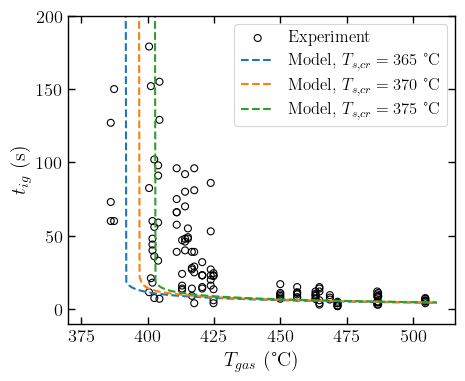

In [29]:
# Load all CSV files matching the pattern
files = glob.glob('results/_THERMAL_MODEL_*.csv')

# Create the plot
plt.figure(figsize=(5, 4))

# Plot experimental data
plt.scatter(df['TC_corrected'], df['t_ig'], edgecolor='k', s=25, color='none', label='Experiment')

T_crit = 394.64
col = '#8b239b'
# plt.axvline(x=T_crit, color=col, linestyle='-', linewidth = 1.5, zorder = -50 , label = '$T_{gas,cr}=395.02$°C')

# Loop through each file and plot the results
for file in files:
    # Extract the T_solid_crit value from the file name
    T_solid_crit = file.split('_')[-4].replace('.csv', '')

    # if T_solid_crit > '375':
    #      continue
        
    # Load the dataframe from the CSV file
    df_results = pd.read_csv(file)
    
    # Replace NaN values in 't_ignition (s)' with 1000 seconds
    df_results['t_ignition (s)'] = df_results['t_ignition (s)'].fillna(1000)
    
    # Plot the theoretical model line
    plt.plot(df_results['T_gas (°C)'], df_results['t_ignition (s)'], linestyle='--', linewidth=1.5, label=f'Model, $T_{{s,cr}}={T_solid_crit}~$°C')

plt.tick_params(axis='both', which='both', direction='in', right=True, top=True )
# Add labels and title
plt.xlabel('$T_{gas}$ (°C)')
plt.ylabel('$t_{ig}$ (s)')
plt.ylim(-10,200)
plt.xlim(370,None)
# Add legend
plt.legend(fontsize=12)
save_path_pdf = os.path.join(results_folder, 'RESULT_wRAD_sim_370_380_390_theo_model.pdf')
plt.savefig(save_path_pdf, bbox_inches='tight')

# Show the plot
plt.show()

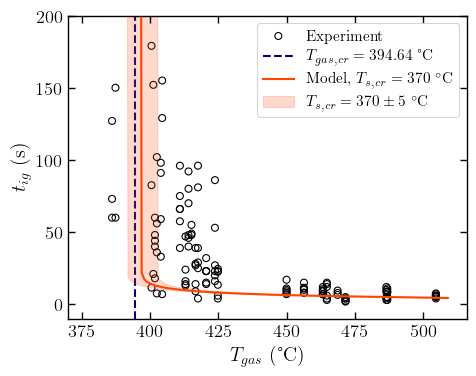

In [31]:
files = glob.glob('results/_THERMAL_MODEL_*.csv')
crimson = '#DC143C'
my_col = 'orangered'
# Prepare storage for model results
model_data = {}

# Plot experimental data
plt.figure(figsize=(5, 4))
plt.scatter(df['TC_corrected'], df['t_ig'], edgecolor='k', s=25, color='none', label='Experiment')
T_crit = 394.64   # from logistic regression
col = '#8b239b'
plt.axvline(x=T_crit, color='navy', linestyle='--', linewidth = 1.5, zorder = -50 , label = f'$T_{{gas,cr}}={T_crit:.2f}~$°C')
# Loop through each file and store the model results
for file in files:
    # Extract the T_solid_crit value from the filename
    T_solid_crit = file.split('_')[-4].replace('.csv', '')
    
    if T_solid_crit > '375':
        continue
    
    # Load and clean the data
    df_results = pd.read_csv(file)
    df_results['t_ignition (s)'] = df_results['t_ignition (s)'].fillna(1000)
    
    # Store results using float key
    T_val = float(T_solid_crit)
    model_data[T_val] = df_results

# Make sure we have all needed keys
if all(t in model_data for t in [365, 370, 375]):
    # Create shared x-axis (gas temperature) from the 370 case
    T_gas_common = model_data[370]['T_gas (°C)'].values
    
    # Interpolate t_ignition values from 365 and 375 to match 370’s x-axis
    t_365 = np.interp(T_gas_common,
                      model_data[365]['T_gas (°C)'],
                      model_data[365]['t_ignition (s)'])
    
    t_375 = np.interp(T_gas_common,
                      model_data[375]['T_gas (°C)'],
                      model_data[375]['t_ignition (s)'])
    
    # Plot central line (370)
    plt.plot(T_gas_common,
             model_data[370]['t_ignition (s)'],
             color=my_col, linewidth=1.5,
             label=r'Model, $T_{s,cr}=370~^\circ$C')
    
    # Fill between 365 and 375
    plt.fill_between(T_gas_common, t_365, t_375,
                     color=my_col, alpha=0.2,
                     label=r'$T_{s,cr} = 370 \pm 5~^{\circ}\mathrm{C}$')

# Final plot adjustments
plt.tick_params(axis='both', which='both', direction='in', right=True, top=True)
plt.xlabel(r'$T_{gas}$ (°C)')
plt.ylabel(r'$t_{ig}$ (s)')
plt.ylim(-10, 200)
plt.xlim(370, None)
plt.legend(loc = 'upper right', fontsize = 11)
plt.tight_layout()
save_path_pdf = os.path.join(results_folder, 'RESULT_wRAD_sim_370_pm5_theo_model.pdf')
plt.savefig(save_path_pdf, bbox_inches='tight')

plt.show()